In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
os.chdir('/app')

In [2]:
df = pd.read_csv('data/raw/creditcard.csv')

In [3]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [92]:
def business_cost(y_true, y_pred, amount):
    """
    Strongly penalize missed fraud (false negatives) and reward true positives by amount.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    amount = np.asarray(amount)

    tp = (y_pred == 1) & (y_true == 1)
    tn = (y_pred == 0) & (y_true == 0)
    fp = (y_pred == 1) & (y_true == 0)
    fn = (y_pred == 0) & (y_true == 1)

    # Adjusted weights
    reward_tp = amount[tp].sum()                            # Catching fraud = full recovery
    reward_tn = 0.01 * amount[tn].sum()                     # Lower reward for legit txn
    cost_fp   = 10 * fp.sum()                               # Customer annoyance
    cost_fn   = 5 * amount[fn].sum() + 100 * fn.sum()       # Missed fraud = heavy penalty

    total = reward_tp + reward_tn - cost_fp - cost_fn

    return total


In [5]:
import sklearn
from sklearn.metrics import make_scorer, recall_score
sklearn.set_config(enable_metadata_routing=True)

business_scorer = make_scorer(business_cost).set_score_request(amount=True)

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Time','Class']) 
y = df.Class

X_tr, X_test, y_tr, y_test, amount_tr, amount_test = train_test_split(X,y,df.Amount,stratify=y,test_size=0.3,random_state=42)

In [11]:
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("http://mlflow:5000")

    
# mlflow.create_experiment("Credit Card Fraud")
mlflow.set_experiment("Credit Card Fraud")

<Experiment: artifact_location='/app/mlruns/1', creation_time=1760905178916, experiment_id='1', last_update_time=1760905178916, lifecycle_stage='active', name='Credit Card Fraud', tags={}>

In [12]:
est = HistGradientBoostingClassifier(random_state=42,validation_fraction=0.2,max_iter=1000, class_weight='balanced')

pipeline = Pipeline([
    ('smote',SMOTE(random_state=42)),
    ('est',est)
])

In [17]:
y_tr.value_counts()

Class
0    199020
1       344
Name: count, dtype: int64

In [73]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV

# ----- Begin MLflow run -----
with mlflow.start_run():

    # Define parameter distributions (random sampling)
    param_dist = {
        "est__learning_rate": np.linspace(0.005, 0.15, 50),
        "est__max_bins": np.arange(10, 255, 2),
        "est__max_depth": np.arange(20, 250, 2),
        "est__l2_regularization": np.logspace(-2, 0, 50),
        "est__max_features": np.logspace(-1, 0, 10),
        "est__min_samples_leaf": np.arange(80, 150, 2),
        "est__max_leaf_nodes": np.arange(80, 250, 2),
    }

    # Create the HalvingRandomSearchCV object
    cv = HalvingRandomSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        factor=3,
        resource='est__max_iter',
        max_resources=1000,
        min_resources=1,
        n_candidates=1000,
        scoring=business_scorer,
        cv=5,
        verbose=1,
        n_jobs=-1,
        random_state=42,
        return_train_score=False
    )

    # Fit the search
    cv.fit(X_tr, y_tr, amount=amount_tr)

    # Log best parameters and metric
    mlflow.log_params(cv.best_params_)
    mlflow.log_metric("best_score_business", cv.best_score_)

    # Log the full trained pipeline
    mlflow.sklearn.log_model(cv.best_estimator_, "model")

    # Optional: tag this run
    mlflow.set_tags({
        "model_type": "GradientBoosting",
        "custom_metric": "business_cost_function",
        "author": "Hadi Ahmed",
        "phase": "tuning"
    })


n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 1
max_resources_: 1000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1000
n_resources: 1
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


/usr/local/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 1
n_candidates: 334
n_resources: 3
Fitting 5 folds for each of 334 candidates, totalling 1670 fits


/usr/local/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 2
n_candidates: 112
n_resources: 9
Fitting 5 folds for each of 112 candidates, totalling 560 fits


/usr/local/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 3
n_candidates: 38
n_resources: 27
Fitting 5 folds for each of 38 candidates, totalling 190 fits


/usr/local/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 4
n_candidates: 13
n_resources: 81
Fitting 5 folds for each of 13 candidates, totalling 65 fits


/usr/local/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 5
n_candidates: 5
n_resources: 243
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 6
n_candidates: 2
n_resources: 729
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
2025/10/19 22:34:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run marvelous-ape-401 at: http://mlflow:5000/#/experiments/1/runs/998eb79cfa5e49a3a8fc32b994f7b1bf
🧪 View experiment at: http://mlflow:5000/#/experiments/1


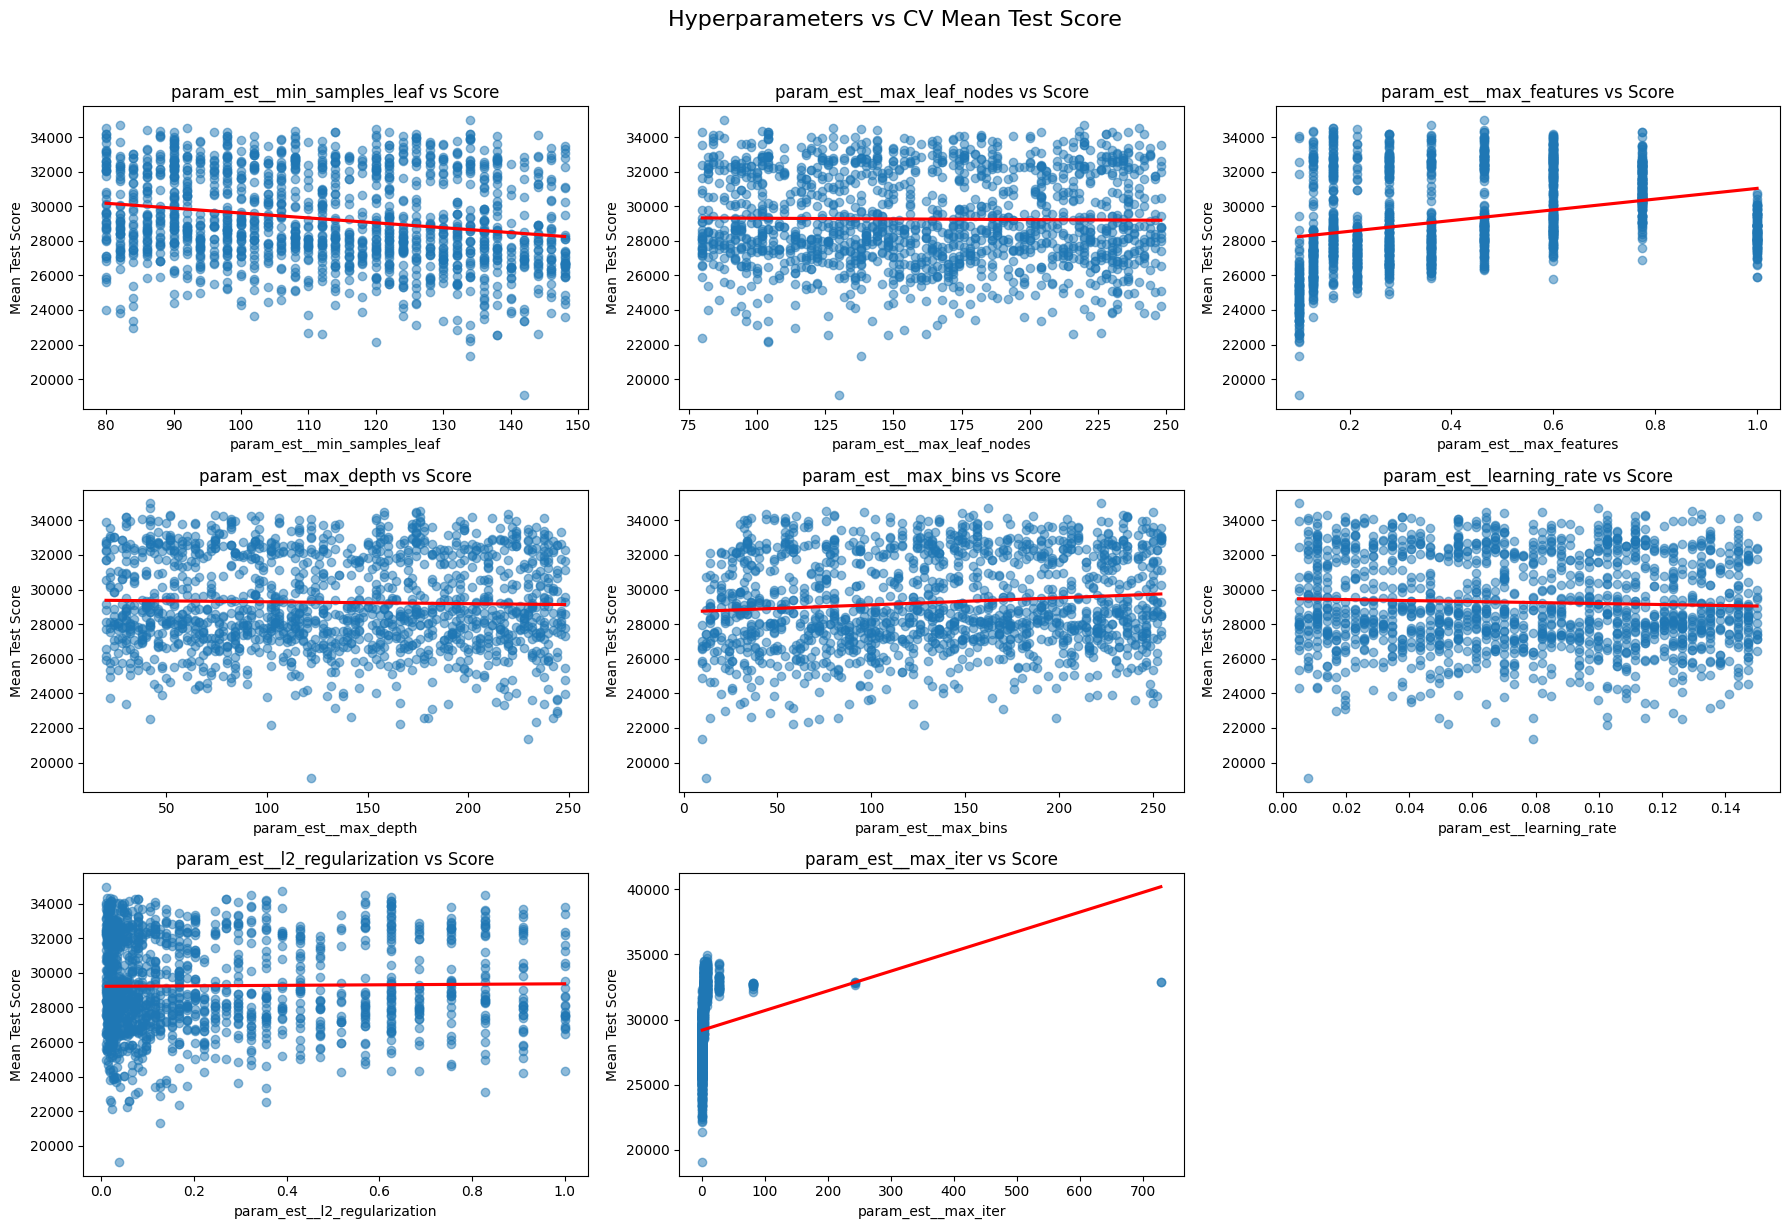

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# After cv.fit(...)
df = pd.DataFrame(cv.cv_results_)

# Identify param columns
param_cols = [c for c in df.columns if c.startswith("param_")]

# Prepare the figure grid size dynamically
n_params = len(param_cols)
n_cols = 3
n_rows = int(np.ceil(n_params / n_cols))

plt.figure(figsize=(n_cols * 6, n_rows * 4))

for i, param in enumerate(param_cols):
    plt.subplot(n_rows, n_cols, i + 1)

    # Detect if categorical
    is_categorical = df[param].dtype == object or df[param].dtype.name == 'category'

    if is_categorical:
        # Boxplot for categorical variables
        sns.boxplot(x=df[paramx], y=df["mean_test_score"])
        plt.xticks(rotation=45)
    else:
        # Scatter + regression line for numeric variables
        # Convert to numeric if needed
        x = pd.to_numeric(df[param], errors='coerce')
        y = df["mean_test_score"]

        sns.regplot(x=x, y=y, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'}, ci=None)
        # Optional: set x-axis to log if param varies over orders of magnitude
        if param in ['param_learning_rate', 'param_l2_regularization', 'param_max_features']:
            plt.xscale('log')

    plt.xlabel(param)
    plt.ylabel("Mean Test Score")
    plt.title(f"{param} vs Score")
    plt.tight_layout()

plt.suptitle("Hyperparameters vs CV Mean Test Score", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()



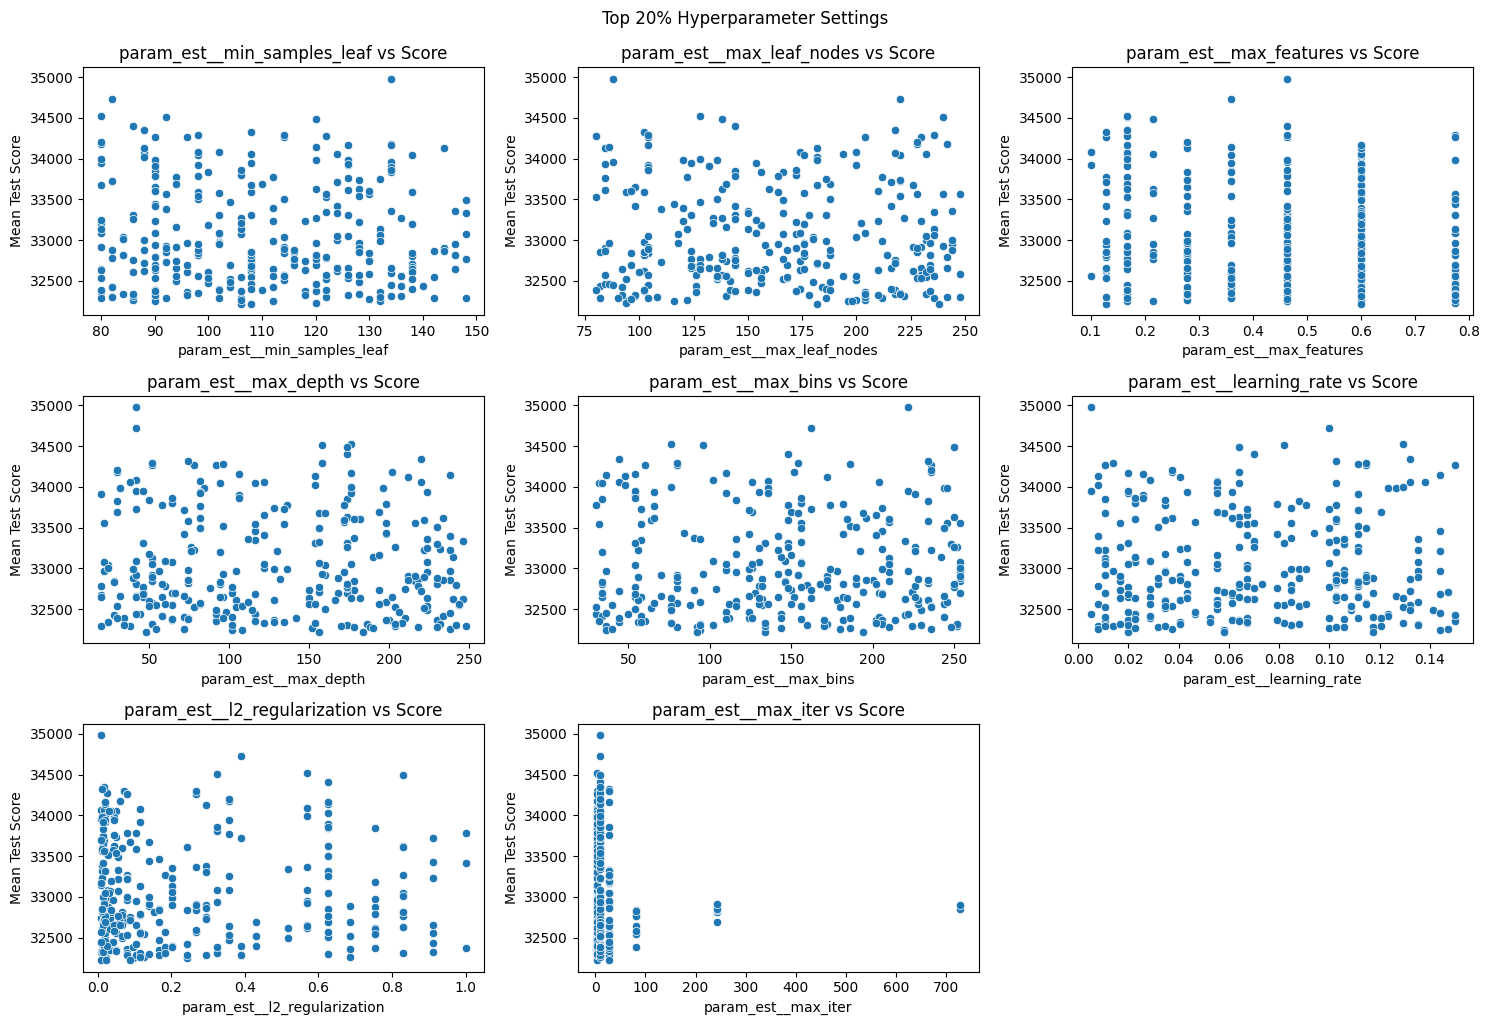

Exception ignored in: <function ResourceTracker.__del__ at 0xffffb4315c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0xffff8077dc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0xffff9b375c60>
Traceback (most recent call last):
  File "/usr

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

top_pct = 0.2
threshold = df['mean_test_score'].quantile(1 - top_pct)
top_df = df[df['mean_test_score'] >= threshold]

param_cols = [c for c in df.columns if c.startswith('param_')]

plt.figure(figsize=(15, 10))
for i, param in enumerate(param_cols):
    plt.subplot(3, 3, i + 1)
    if param in ['param_learning_rate', 'param_l2_regularization', 'param_max_features']:
        sns.scatterplot(x=top_df[param], y=top_df['mean_test_score'])
        plt.xscale('log')
    else:
        sns.scatterplot(x=top_df[param], y=top_df['mean_test_score'])
    plt.xlabel(param)
    plt.ylabel('Mean Test Score')
    plt.title(f'{param} vs Score')
    plt.tight_layout()

plt.suptitle('Top 20% Hyperparameter Settings', y=1.02)
plt.show()


In [76]:
def parse_mlflow_params(raw_params, step_name='est'):
    parsed_params = {}
    for k, v in raw_params.items():
        if not k.startswith(f'{step_name}__'):
            continue
        param_name = k.replace(f'{step_name}__', '')
        # Try to cast to float or int
        try:
            if '.' in v:
                parsed_params[f'{step_name}__{param_name}'] = float(v)
            else:
                parsed_params[f'{step_name}__{param_name}'] = int(v)
        except ValueError:
            parsed_params[f'{step_name}__{param_name}'] = v  # Leave as string
    return parsed_params

params = mlflow.get_run('998eb79cfa5e49a3a8fc32b994f7b1bf').data.params
clean_params = parse_mlflow_params(params)
pipeline.set_params(**clean_params)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('est',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                l2_regularization=0.2682695795279725,
                                                learning_rate=0.11448979591836735,
                                                max_bins=80, max_depth=52,
                                                max_features=0.46415888336127786,
                                                max_iter=729,
                                                max_leaf_nodes=104,
                                                min_samples_leaf=114,
                                                random_state=42,
                                                validation_fraction=0.2))])

In [77]:
pipeline.fit(X_tr,y_tr)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('est',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                l2_regularization=0.2682695795279725,
                                                learning_rate=0.11448979591836735,
                                                max_bins=80, max_depth=52,
                                                max_features=0.46415888336127786,
                                                max_iter=729,
                                                max_leaf_nodes=104,
                                                min_samples_leaf=114,
                                                random_state=42,
                                                validation_fraction=0.2))])

In [78]:
from sklearn.metrics import confusion_matrix, classification_report
print("Training set results:")
print(confusion_matrix(y_tr,pipeline.predict(X_tr)))

print(
    classification_report(y_tr,pipeline.predict(X_tr))
)

Training set results:
[[199009     11]
 [     0    344]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       0.97      1.00      0.98       344

    accuracy                           1.00    199364
   macro avg       0.98      1.00      0.99    199364
weighted avg       1.00      1.00      1.00    199364



In [79]:
fn_mask = (pipeline.predict(X_tr)==0) & (y_tr==1)

X_tr[fn_mask].Amount

Series([], Name: Amount, dtype: float64)

In [82]:
from sklearn.model_selection import TunedThresholdClassifierCV


tuned_pipeline = TunedThresholdClassifierCV(pipeline,cv=5,scoring=business_scorer,response_method='decision_function')

In [87]:
tuned_pipeline.fit(X_tr,y_tr,amount=amount_tr)

TunedThresholdClassifierCV(cv=5,
                           estimator=Pipeline(steps=[('smote',
                                                      SMOTE(random_state=42)),
                                                     ('est',
                                                      HistGradientBoostingClassifier(class_weight='balanced',
                                                                                     l2_regularization=0.2682695795279725,
                                                                                     learning_rate=0.11448979591836735,
                                                                                     max_bins=80,
                                                                                     max_depth=52,
                                                                                     max_features=0.46415888336127786,
                                                                                     max_iter=729,
                                                                                     max_leaf_nodes=104,
                                                                                     min_samples_leaf=114,
                                                                                     random_state=42,
                                                                                     validation_fraction=0.2))]),
                           response_method='decision_function',
                           scoring=make_scorer(business_cost, response_method='predict'))

In [88]:
from sklearn.metrics import confusion_matrix, classification_report
print("Training set results:")

y_tr_preds = tuned_pipeline.predict(X_tr)

print(confusion_matrix(y_tr,y_tr_preds))

print(
    classification_report(y_tr,y_tr_preds)
)

Training set results:
[[198879    141]
 [     0    344]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       0.71      1.00      0.83       344

    accuracy                           1.00    199364
   macro avg       0.85      1.00      0.91    199364
weighted avg       1.00      1.00      1.00    199364



In [56]:
X_tr[(y_tr_preds!=y_tr) & (y_tr==1)].Amount

Series([], Name: Amount, dtype: float64)

In [90]:
from sklearn.metrics import confusion_matrix, classification_report
print("Test set results:")

y_test_preds = tuned_pipeline.predict(X_test)

print(confusion_matrix(y_test,y_test_preds))

print(
    classification_report(y_test,y_test_preds)
)

Test set results:
[[85115   180]
 [   22   126]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.41      0.85      0.56       148

    accuracy                           1.00     85443
   macro avg       0.71      0.92      0.78     85443
weighted avg       1.00      1.00      1.00     85443



In [91]:
X_test[(y_test_preds!=y_test) & (y_test==1)].Amount

245347       2.47
191074     720.80
20198      104.81
96341       98.01
623        529.00
157918     635.10
219025       4.49
68067      519.90
222419       0.00
192687     276.17
72757        1.79
245556     357.95
119714      29.95
157585       1.00
254395       7.59
249239    1096.99
100623     549.06
101509     320.00
254344     187.11
124036     129.00
275992     634.30
50537        1.00
Name: Amount, dtype: float64

In [33]:
import mlflow.sklearn
from mlflow.models.signature import infer_signature

with mlflow.start_run():
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="fraud_model",
        signature=infer_signature(X_tr, pipeline.predict(X_tr)),
        registered_model_name="credit_card_fraud_model"  # Optional
    )


2025/10/08 20:17:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'credit_card_fraud_model'.
2025/10/08 20:17:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: credit_card_fraud_model, version 1
Created version '1' of model 'credit_card_fraud_model'.


🏃 View run fun-duck-236 at: http://host.docker.internal:5000/#/experiments/1/runs/91ba459cf59b49d2813560d27dd1d6f6
🧪 View experiment at: http://host.docker.internal:5000/#/experiments/1


array([-1.35980713e+00, -7.27811733e-02,  2.53634674e+00,  1.37815522e+00,
       -3.38320770e-01,  4.62387778e-01,  2.39598554e-01,  9.86979013e-02,
        3.63786970e-01,  9.07941720e-02, -5.51599533e-01, -6.17800856e-01,
       -9.91389847e-01, -3.11169354e-01,  1.46817697e+00, -4.70400525e-01,
        2.07971242e-01,  2.57905802e-02,  4.03992960e-01,  2.51412098e-01,
       -1.83067779e-02,  2.77837576e-01, -1.10473910e-01,  6.69280749e-02,
        1.28539358e-01, -1.89114844e-01,  1.33558377e-01, -2.10530535e-02,
        1.49620000e+02])

In [39]:
import requests

url = "http://mlflow-serve:1234/invocations"
headers = {"Content-Type": "application/json"}

# Example input — depends on what your model expects!
# Must be a pandas-compatible JSON (records-orient)
data = {
    "dataframe_split": {
        "columns": list(X.columns),
        "data": [X.loc[215984].values.tolist()]  # <- a single prediction row
    }
}

response = requests.post(url, json=data, headers=headers)
print("Prediction:", response.json())


Prediction: {'predictions': [1]}


In [40]:
response.json()

{'predictions': [1]}

In [41]:
X_tr[y==1]

/tmp/ipykernel_49/3244383732.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_tr[y==1]


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
41943,-2.140511,4.104871,-8.996859,4.028391,-5.131359,-4.153568,-9.360095,1.922075,-4.026180,-13.691315,...,1.725578,1.854267,-0.165534,-0.339939,0.296314,1.364225,-0.518996,2.352333,1.130625,0.76
150677,-13.086519,7.352148,-18.256576,10.648505,-11.731476,-3.659167,-14.873658,8.810473,-5.418204,-13.202577,...,-1.376298,2.761157,-0.266162,-0.412861,0.519952,-0.743909,-0.167808,-2.498300,-0.711066,30.31
215132,-2.921944,-0.228062,-5.877289,2.201884,-1.935440,0.631141,-1.245106,1.511348,-1.899987,-6.428231,...,2.230735,1.441622,0.895528,1.385511,-2.028024,0.509131,0.172643,0.726781,0.234514,723.21
215984,-4.861747,-2.722660,-4.656248,2.502005,-2.008346,0.615422,-3.485680,1.878856,-1.116268,-5.112971,...,0.285559,1.138876,1.033664,-0.806199,-1.511046,-0.191731,0.080999,1.215152,-0.923142,592.90
154286,-1.465316,-1.093377,-0.059768,1.064785,11.095089,-5.430971,-9.378025,-0.446456,1.992110,1.785922,...,-1.457610,1.160623,-1.259697,-15.981649,-0.883670,-3.536716,-0.592965,0.675525,0.424849,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70141,-1.649279,1.263974,-1.050826,2.237991,-2.527889,-0.889940,-2.355254,0.854659,-1.281243,-2.705011,...,0.087406,0.679176,0.731907,0.333045,0.392505,-0.274197,0.802349,0.390809,0.112146,112.45
6641,0.857321,4.093912,-7.423894,7.380245,0.973366,-2.730762,-1.496497,0.543015,-2.351190,-3.944238,...,0.483303,0.375026,0.145400,0.240603,-0.234649,-1.004881,0.435832,0.618324,0.148469,1.00
229730,1.894036,1.905806,-3.515730,4.508913,2.044466,-1.420468,1.057480,-0.281157,-1.832604,-0.628463,...,-0.160163,-0.144713,-0.310108,-0.101530,-0.414960,0.376597,0.150778,-0.013712,0.048084,2.22
151009,-26.457745,16.497472,-30.177317,8.904157,-17.892600,-1.227904,-31.197329,-11.438920,-9.462573,-22.187089,...,2.812241,-8.755698,3.460893,0.896538,0.254836,-0.738097,-0.966564,-7.263482,-1.324884,1.00
